# IMPORTANDO DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
df = pd.read_csv("/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_alopuno.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Fecha             5166 non-null   object
 1   Hora de salida    5166 non-null   object
 2   Lugar de Origen   5166 non-null   object
 3   Lugar de Destino  5166 non-null   object
dtypes: object(4)
memory usage: 161.6+ KB
None


# LIMPIEZA

In [ ]:
duplicados = df[df["Lugar de Origen"] == df["Lugar de Destino"]].copy()

print("\n- Registros erróneos detectados (mismo origen y destino):")
print(duplicados)
print(f"\n- Total de registros erróneos: {len(duplicados)}")

df = df[df["Lugar de Origen"] != df["Lugar de Destino"]].copy()

df["ID"] = range(1, len(df) + 1)

print("\n- Registros válidos después de eliminar errores:", len(df))



- Registros erróneos detectados (mismo origen y destino):
           Fecha Hora de salida  \
18    2024-06-01       14:31:00   
166   2024-06-06       20:40:00   
270   2024-06-10       16:25:00   
338   2024-06-13       06:47:00   
360   2024-06-13       20:38:00   
...          ...            ...   
4808  2024-11-18       08:44:00   
4920  2024-11-22       13:39:00   
5042  2024-11-26       15:34:00   
5061  2024-11-27       10:08:00   
5115  2024-11-29       12:00:00   

                                       Lugar de Origen  \
18    Universidad Andina Néstor Cáceres Velásquez Puno   
166                                Avenida Floral Puno   
270                 Instituto Americano Los Andes Puno   
338                              Hospital ESSALUD Puno   
360              Hospital Regional Manuel Núñez Butrón   
...                                                ...   
4808                  Municipalidad Provincial de Puno   
4920                                Av. Costanera Puno  

# ANÁLISIS

In [ ]:
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
if df['Fecha'].isnull().any():
    print("Hay fechas no válidas que se ignorarán en el cálculo")

viajes_por_dia = df.groupby(df['Fecha'].dt.date).size()
promedio_viajes = viajes_por_dia.mean()

print(f"- Total de días considerados: {len(viajes_por_dia)}")
print(f"- Promedio de viajes por día: {promedio_viajes:.0f}")
print("\nEjemplo de viajes por día (primeros 10 días):")
print(viajes_por_dia.head(10))


- Total de días considerados: 183
- Promedio de viajes por día: 28

Ejemplo de viajes por día (primeros 10 días):
Fecha
2024-06-01    34
2024-06-02    27
2024-06-03    24
2024-06-04    27
2024-06-05    26
2024-06-06    28
2024-06-07    28
2024-06-08    31
2024-06-09    29
2024-06-10    24
dtype: int64


In [ ]:
# Contar la frecuencia de cada lugar en columnas Origen y Destino
lugares_origen = df['Lugar de Origen'].value_counts()
lugares_destino = df['Lugar de Destino'].value_counts()

# Sumar ambos conteos para obtener total de veces recorridos
total_lugares = lugares_origen.add(lugares_destino, fill_value=0)

# Ordenar de mayor a menor y obtener los 5 más recorridos
top_5_lugares = total_lugares.sort_values(ascending=False).head(5)

print("Los 5 lugares más recorridos son:")
print(top_5_lugares)


Los 5 lugares más recorridos son:
Jirón Lima Puno                       364
Plaza Mayor de Puno Puno              333
Puerto Lacustre Puno                  327
Real Plaza Puno                       319
Universidad Nacional del Altiplano    305
Name: count, dtype: int64


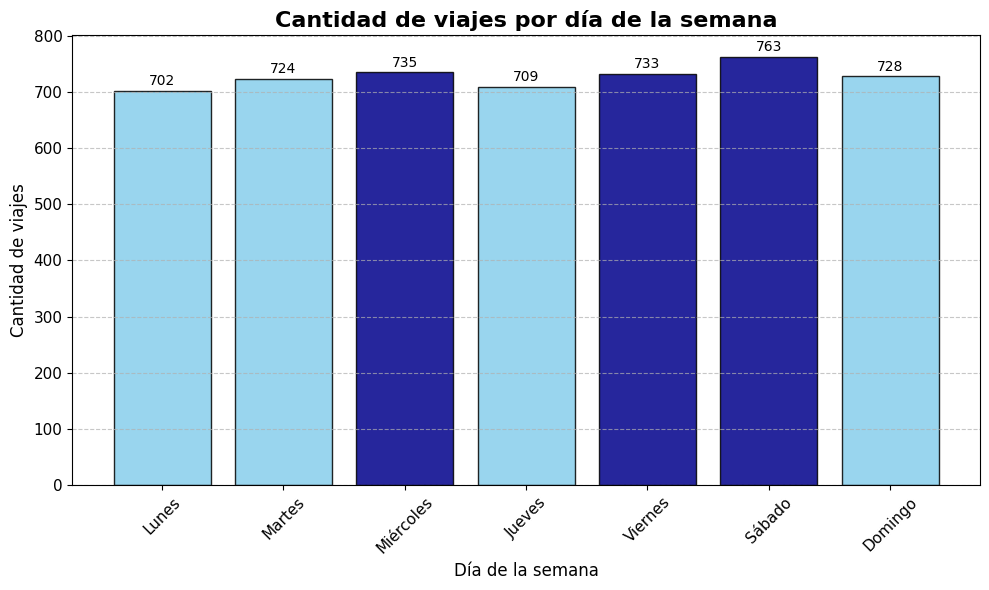

In [ ]:
import matplotlib.pyplot as plt

fechas = pd.to_datetime(df['Fecha'], errors='coerce')

viajes_por_dia = fechas.dt.day_name().value_counts()
dias_semana_esp = {'Monday': 'Lunes','Tuesday': 'Martes','Wednesday': 'Miércoles','Thursday': 'Jueves','Friday': 'Viernes','Saturday': 'Sábado','Sunday': 'Domingo'
}

viajes_por_dia = viajes_por_dia.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])


viajes_por_dia.index = [dias_semana_esp[d] for d in viajes_por_dia.index]

colores = ['skyblue'] * len(viajes_por_dia)
top3_indices = viajes_por_dia.nlargest(3).index
for i, dia in enumerate(viajes_por_dia.index):
    if dia in top3_indices:
        colores[i] = 'darkblue'

# --- Graficar ---
plt.figure(figsize=(10,6))
bars = plt.bar(viajes_por_dia.index, viajes_por_dia.values, color=colores, edgecolor='black', alpha=0.85)

for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 5, str(altura), ha='center', va='bottom', fontsize=10)

plt.title('Cantidad de viajes por día de la semana', fontsize=16, fontweight='bold')
plt.xlabel('Día de la semana', fontsize=12)
plt.ylabel('Cantidad de viajes', fontsize=12)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

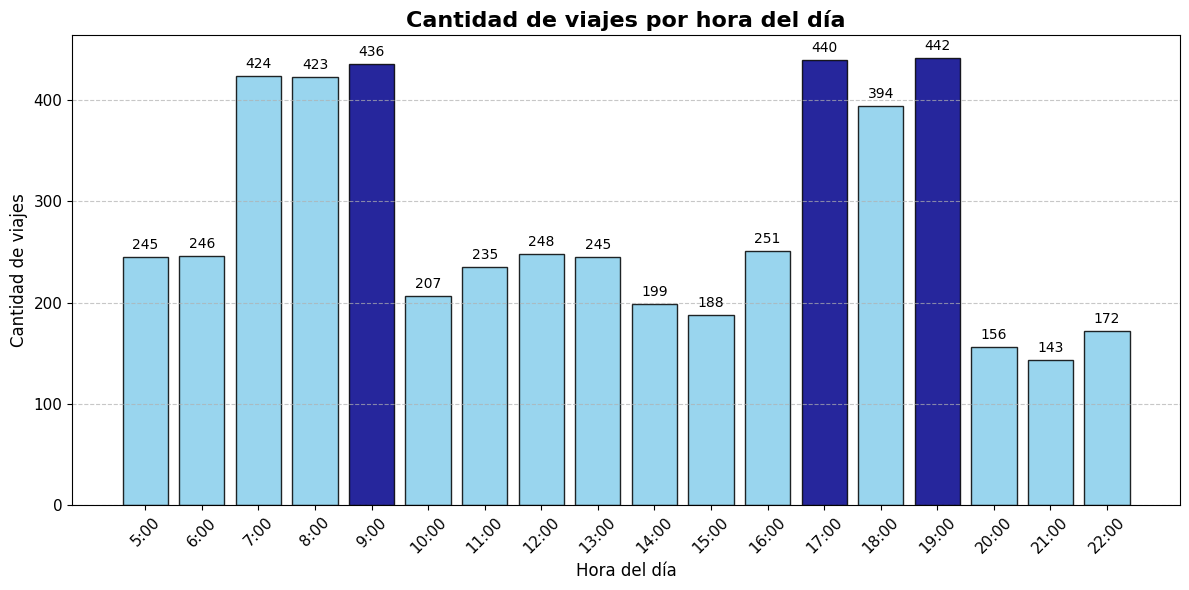

In [ ]:
horas = pd.to_datetime(df['Hora de salida'], format='%H:%M:%S', errors='coerce').dt.hour

viajes_por_hora = horas.value_counts().sort_index()

colores = ['skyblue'] * len(viajes_por_hora)
top3_indices = viajes_por_hora.nlargest(3).index
for i, h in enumerate(viajes_por_hora.index):
    if h in top3_indices:
        colores[i] = 'darkblue'

# --- Graficar ---
plt.figure(figsize=(12,6))
bars = plt.bar(viajes_por_hora.index, viajes_por_hora.values, color=colores, edgecolor='black', alpha=0.85)

for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 5, str(altura), ha='center', va='bottom', fontsize=10)

plt.title('Cantidad de viajes por hora del día', fontsize=16, fontweight='bold')
plt.xlabel('Hora del día', fontsize=12)
plt.ylabel('Cantidad de viajes', fontsize=12)
plt.xticks(viajes_por_hora.index, [f"{h}:00" for h in viajes_por_hora.index], rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# GEOCODIFICACION

In [ ]:
origenes = df['Lugar de Origen'].dropna().unique()
destinos = df['Lugar de Destino'].dropna().unique()

lugares_unicos = sorted(set(origenes) | set(destinos))
def geocode_with_retry(lugar, geolocator, retries=3, delay=1):
    for i in range(retries):
        try:
            location = geolocator.geocode(f"{lugar}, Puno, Perú", timeout=10)
            if location:
                return location.latitude, location.longitude
            else:
                return None, None
        except GeocoderTimedOut:
            print(f"o Timeout con {lugar}, reintentando ({i+1}/{retries})...")
            time.sleep(delay)
        except Exception as e:
            print(f"x Error con {lugar}: {e}")
            return None, None
    return None, None

geolocator = Nominatim(user_agent="tesis_rutas_puno")
coordenadas = []
for lugar in lugares_unicos:
    lat, lon = geocode_with_retry(lugar, geolocator)
    coordenadas.append((lugar, lat, lon))
    if lat and lon:
        print(f"o {lugar} → {lat}, {lon}")
    else:
        print(f"x No se encontró: {lugar}")
    time.sleep(1)

df_coords = pd.DataFrame(coordenadas, columns=["Lugar", "Latitud", "Longitud"])
reubicaciones = {
    "Complejo Deportivo Alto Llavini Puno": (-15.8470, -70.0250),
    "Gran Unidad Escolar San Carlos Puno": (-15.8385, -70.0240),
    "Hospital Regional Manuel Núñez Butrón": (-15.8515, -70.0180),
    "Hotel Libertador Lago Titicaca Puno": (-15.8380, -70.0170),
    "Iglesia San Juan Bautista Puno": (-15.8410, -70.0260),
    "Instituto Americano Los Andes Puno": (-15.8375, -70.0245),
    "Instituto de Cultura y Turismo de Puno": (-15.8420, -70.0265),
    "Instituto de Educación Superior Tecnológico Público Puno": (-15.8450, -70.0220),
    "Plazuela 15 de Agosto Puno": (-15.8390, -70.0265),
    "Plazuela Santa Rosa Puno": (-15.8385, -70.0270),
    "Polideportivo Chanu Chanu Puno": (-15.8600, -70.0140),
    "Puerto Lacustre Puno": (-15.8491, -70.0185),
    "Puerto Muñoz Díaz Puno": (-15.8485, -70.0190),
    "Urbanización Huajsapata Puno": (-15.8560, -70.0235),
    "Los Incas Puno": (-15.8400, -70.0280),
    "Colegio Don Bosco Puno": (-15.8282, -70.0481),
    "Hospital ESSALUD Puno": (-15.8400, -70.0213),
    "Parque del Niño Puno": (-15.8410, -70.0240),
    "Municipalidad Provincial de Puno": (-15.8400, -70.0250),
    "Terminal Terrestre Puno": (-15.8480, -70.0146),
    "Real Plaza Puno": (-15.8426, -70.0141),
    "Urbanización Alto Puno": (-15.8282, -70.0481),
    "Urbanización Bellavista Puno": (-15.8400, -70.0280)
}

def corregir_coordenadas(row):
    if row["Lugar"] in reubicaciones:
        print(f"- Reubicado manualmente: {row['Lugar']} → {reubicaciones[row['Lugar']]}")
        return reubicaciones[row["Lugar"]]
    else:
        return row["Latitud"], row["Longitud"]

df_coords["Latitud"], df_coords["Longitud"] = zip(*df_coords.apply(corregir_coordenadas, axis=1))

coordenadas_dict = dict(zip(df_coords["Lugar"], zip(df_coords["Latitud"], df_coords["Longitud"])))
print("\nDiccionario de coordenadas final:")
print(coordenadas_dict)

o Av. Costanera Puno → -15.8399095, -70.0176539
o Avenida El Sol Puno → -15.8458219, -70.0202123
o Avenida Floral Puno → -15.8268687, -70.0141471
o Avenida La Torre Puno → -15.8336052, -70.0276202
o Catedral Basílica de Puno → -15.8409556, -70.029004
o Cementerio Laykakota Puno → -15.8492522, -70.0210575
o Cementerio Yanamayo Puno → -15.8096272, -70.0300562
o Centro de Salud Metropolitano Puno → -15.8434283, -70.0213117
o Colegio Adventista Puno → -15.8366071, -70.0291852
o Colegio Don Bosco Puno → -15.5301, -70.0939
o Colegio Glorioso San Carlos Puno → -15.8348219, -70.0245958
o Colegio María Auxiliadora Puno → -15.8379872, -70.0329811
x No se encontró: Complejo Deportivo Alto Llavini Puno
o Estadio Enrique Torres Belón → -15.8370214, -70.0219969
o Gobierno Regional de Puno → -15.8400211, -70.0276698
x No se encontró: Gran Unidad Escolar San Carlos Puno
o Hospital ESSALUD Puno → -15.493844, -70.1360276
x No se encontró: Hospital Regional Manuel Núñez Butrón
o Hostal Mirador Korichasca

# DATA AUGMENTED

In [ ]:
import pandas as pd
import numpy as np
import random
import math
from datetime import datetime, timedelta

def coordenadas_a_string(lugar):
    coord = coordenadas_dict.get(lugar, (None, None))
    lat, lon = coord
    if lat is None or lon is None:
        return ""
    return f"{lat},{lon}"

def asignar_hora_salida():
    horas = list(range(24))
    pesos = []
    for h in horas:
        if 7 <= h <= 9 or 17 <= h <= 20:
            pesos.append(4)
        else:
            pesos.append(3)
    pesos = np.array(pesos) / np.sum(pesos)
    hora = np.random.choice(horas, p=pesos)
    minuto = random.randint(0, 59)
    return datetime(2024, 1, 1, hora, minuto).time()

def generar_dataset_sintetico(df_original, total_registros=25000, archivo_salida="rutas_alopuno_sintetico.csv"):
    synthetic_data = []

    lugares_unicos = pd.unique(df_original[['Lugar de Origen', 'Lugar de Destino']].values.ravel())

    fecha_min = pd.to_datetime(df_original["Fecha"].min())
    fecha_max = pd.to_datetime(df_original["Fecha"].max())

    for lugar in lugares_unicos:
        posibles_destinos = [l for l in lugares_unicos if l != lugar]
        destino = random.choice(posibles_destinos)

        coord_origen = df_original[df_original["Lugar de Origen"] == lugar]["Coordenadas Origen"]
        coord_destino = df_original[df_original["Lugar de Destino"] == destino]["Coordenadas Destino"]

        if coord_origen.empty:
            coord_origen = df_original["Coordenadas Origen"].sample(1).values[0]
        else:
            coord_origen = coord_origen.sample(1).values[0]

        if coord_destino.empty:
            coord_destino = df_original["Coordenadas Destino"].sample(1).values[0]
        else:
            coord_destino = coord_destino.sample(1).values[0]

        fecha_random = fecha_min + (fecha_max - fecha_min) * random.random()
        hora_salida = asignar_hora_salida()

        synthetic_data.append([
            lugar,
            coord_origen,
            destino,
            coord_destino,
            fecha_random.date(),
            hora_salida
        ])

    faltantes = total_registros - len(synthetic_data)
    for _ in range(faltantes):
        row = df_original.sample(1).iloc[0]

        origen = row["Lugar de Origen"]
        destino = row["Lugar de Destino"]
        while destino == origen:
            destino = df_original["Lugar de Destino"].sample(1).values[0]

        coord_origen = row["Coordenadas Origen"]
        coord_destino = df_original[df_original["Lugar de Destino"] == destino]["Coordenadas Destino"].sample(1).values[0]

        fecha_random = fecha_min + (fecha_max - fecha_min) * random.random()
        hora_salida = asignar_hora_salida()

        synthetic_data.append([
            origen,
            coord_origen,
            destino,
            coord_destino,
            fecha_random.date(),
            hora_salida
        ])

    df_sintetico = pd.DataFrame(synthetic_data, columns=[
        "Lugar de Origen", "Coordenadas Origen",
        "Lugar de Destino", "Coordenadas Destino",
        "Fecha", "Hora de Salida"
    ])
    df_sintetico.insert(0, "ID", range(1, len(df_sintetico) + 1))
    df_sintetico.to_csv(archivo_salida, index=False, encoding="utf-8")

    return df_sintetico

df = pd.read_csv("/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_alopuno.csv")

df["Coordenadas Origen"] = df["Lugar de Origen"].apply(coordenadas_a_string)
df["Coordenadas Destino"] = df["Lugar de Destino"].apply(coordenadas_a_string)

df_sintetico = generar_dataset_sintetico(
    df,
    total_registros=25000,
    archivo_salida="/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_alopuno_25k.csv"
)

print(df_sintetico.head())
print(f"\nTotal registros generados: {len(df_sintetico)}")

   ID                        Lugar de Origen       Coordenadas Origen  \
0   1                   Parque del Niño Puno          -15.841,-70.024   
1   2  Hospital Regional Manuel Núñez Butrón         -15.8515,-70.018   
2   3         Polideportivo Chanu Chanu Puno           -15.86,-70.014   
3   4               Plaza Mayor de Puno Puno  -15.8405942,-70.0279834   
4   5               Cementerio Yanamayo Puno  -15.8096272,-70.0300562   

                         Lugar de Destino      Coordenadas Destino  \
0                         Jirón Lima Puno  -15.8387563,-70.0281599   
1  Instituto de Cultura y Turismo de Puno         -15.842,-70.0265   
2                  Colegio Don Bosco Puno        -15.8282,-70.0481   
3                         Real Plaza Puno        -15.8426,-70.0141   
4                  Urbanización Alto Puno        -15.8282,-70.0481   

        Fecha Hora de Salida  
0  2024-07-14       07:51:00  
1  2024-10-05       11:03:00  
2  2024-06-26       12:22:00  
3  2024-06-04   